In [1]:
pip install mf2

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mf2.forrester import forrester
from skopt import gp_minimize
from skopt.space import Real
from skopt.plots import plot_convergence
from scipy.integrate import trapz
from skopt.utils import use_named_args
from skopt import Optimizer
from collections import namedtuple

In [3]:
# 1. ✅ objective 함수 정의
def get_objective_function(mf_function, fidelity='high'):
    """Returns a callable high- or low-fidelity function"""
    def func(x):
        x = np.array(x).reshape(1, -1)
        return mf_function[fidelity](x)[0]
    return func


# 2. ✅ 베이지안 최적화 수행 함수
def run_bayesian_optimization(mf_function, fidelity='high', n_calls=20, random_state=1004):
    """Runs Bayesian Optimization using a specified fidelity"""
    dim = len(mf_function.l_bound)
    space = [Real(l, u) for l, u in zip(mf_function.l_bound, mf_function.u_bound)]
    
    objective = get_objective_function(mf_function, fidelity=fidelity)
    
    result = gp_minimize(
        func=objective,
        dimensions=space,
        n_calls=n_calls,
        random_state=random_state,
        verbose=True
    )
    return result

def run_random_search(mf_function, fidelity='high', n_calls=20, random_state=1004):
    """
    Random Search 기반의 최적화 (단순 무작위 샘플링)
    mf_function: MultiFidelityFunction object (e.g., forrester)
    fidelity: 'high' 또는 'low'
    n_calls: 총 시도 횟수
    """
    dim = len(mf_function.l_bound)
    rng = np.random.RandomState(random_state)

    # n_calls 개의 점을 dim 차원 범위 내에서 샘플링
    X = rng.uniform(low=mf_function.l_bound, high=mf_function.u_bound, size=(n_calls, dim))

    # 함수 선택
    func = mf_function[fidelity]

    # 평가
    Y = [func(x.reshape(1, -1))[0] for x in X]

    # 최적값 추적
    best_idx = int(np.argmin(Y))
    best_x = X[best_idx].tolist()
    best_fun = Y[best_idx]

    # Mock skopt-like 결과 객체 반환
    Result = namedtuple("OptimizeResult", ["x", "fun", "func_vals", "x_iters"])
    return Result(x=best_x, fun=best_fun, func_vals=np.array(Y), x_iters=X.tolist())

def analyse_optimization_results(results_dict, true_optimum=None, epsilon=None):
    names = []
    means = []
    stds = []
    regrets = []
    aucs = []
    all_best_values = {}  # 👈 여기에 각 optimizer별 best values 저장!

    for name, runs in results_dict.items():
        best_values = [res.fun for res in runs]
        iters = [res.func_vals for res in runs]

        best_mean = np.mean(best_values)
        best_std = np.std(best_values)

        auc = np.mean([trapz(np.minimum(fv, best_mean), dx=1) for fv in iters])

        if true_optimum is not None:
            mean_regret = np.mean([abs(f - true_optimum) for f in best_values])
        else:
            mean_regret = np.nan

        names.append(name)
        means.append(best_mean)
        stds.append(best_std)
        regrets.append(mean_regret)
        aucs.append(auc)
        all_best_values[name] = best_values  # ✅ 추가

    return {
        'names': names,
        'best_mean': means,
        'best_std': stds,
        'regret': regrets,
        'auc': aucs,
        'all_best_values': all_best_values  # ✅ 추가
    }




In [4]:
def analyse_success_steps(results_dict, threshold=3000, max_calls=30):
    """
    각 optimizer가 threshold 값을 몇 번째 평가에서 처음 달성했는지 측정
    
    Returns:
        success_steps: dict of {optimizer: list of evaluation step index}
    """
    success_steps = {}

    for name, runs in results_dict.items():
        steps = []
        for res in runs:
            y = res.func_vals
            success_idx = next((i + 1 for i, val in enumerate(y) if val >= threshold), max_calls + 1)
            steps.append(success_idx)
        success_steps[name] = steps

    return success_steps


In [5]:
def plot_mf_function_with_samples(mf_function, result=None, num_points=1000, title=None):
    """
    1차원 multi-fidelity 함수 시각화 + 탐색한 점들 표시
    
    Parameters:
    - mf_function: MultiFidelityFunction 객체
    - result: skopt OptimizeResult (또는 mock 결과)
    - num_points: 그래프를 그릴 점 개수
    - title: 제목 (없으면 함수 이름)
    """
    # 1차원 확인
    dim = len(mf_function.l_bound)
    if dim != 1:
        raise ValueError("이 시각화는 1차원 함수만 지원합니다.")

    # X축 정의
    x_min, x_max = mf_function.l_bound[0], mf_function.u_bound[0]
    X = np.linspace(x_min, x_max, num_points).reshape(-1, 1)
    
    # 함수값 계산
    Y_high = mf_function['high'](X)
    Y_low = mf_function['low'](X)

    # 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(X, Y_high, label='High Fidelity', linewidth=2)
    plt.plot(X, Y_low, label='Low Fidelity', linestyle='--')

    # 탐색된 점 표시
    if result is not None:
        x_iters = np.array(result.x_iters)
        y_evals = result.func_vals

        plt.scatter(x_iters, y_evals, color='red', label='Sampled Points', zorder=5)

    plt.title(title or f"{mf_function.name} (1D) + Sampled Points")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




def plot_optimizer_comparison(metrics, figsize=(12, 5)):
    """
    metrics: dict returned by updated analyse_optimization_results
             and should include 'all_best_values' key
    """
    names = metrics['names']
    all_best_values = metrics['all_best_values']  # dict of optimizer name -> list of best values

    plt.figure(figsize=figsize)

    # 1. Boxplot of Best Found Values
    plt.subplot(1, 3, 1)
    data = [all_best_values[name] for name in names]
    plt.boxplot(data, labels=names, showfliers=True)
    plt.title("Best Found (Boxplot)")
    plt.ylabel("Objective value")
    plt.xticks(rotation=30)
    plt.grid(True)

    # 2. Regret (bar plot)
    plt.subplot(1, 3, 2)
    x = np.arange(len(names))
    plt.bar(x, metrics['regret'])
    plt.title("Regret")
    plt.ylabel("Mean Regret")
    plt.xticks(x, names, rotation=30)
    plt.grid(True)

    # 3. AUC (bar plot)
    plt.subplot(1, 3, 3)
    plt.bar(x, metrics['auc'])
    plt.title("AUC of Convergence")
    plt.ylabel("Area Under Curve")
    plt.xticks(x, names, rotation=30)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_success_steps(success_steps):
    """
    박스플롯으로 각 optimizer가 threshold를 몇 번째에 넘었는지 비교
    """
    names = list(success_steps.keys())
    data = [success_steps[name] for name in names]

    plt.figure(figsize=(8, 5))
    plt.boxplot(data, labels=names, showfliers=True)
    plt.title("Evaluation Steps to Reach f(x) ≥ Threshold")
    plt.ylabel("Number of Evaluations")
    plt.grid(True)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


In [6]:
forrester.u_bound = [10]
forrester.u_bound

[10]

In [7]:
forrester.l_bound = [-10]
forrester.l_bound

[-10]

In [12]:
# 5번씩 반복한 결과
n_calls = 500

results_dict = {
    "BayesOpt": [run_bayesian_optimization(forrester, n_calls=n_calls) for _ in range(10)],
    "RandomSearch": [run_random_search(forrester, n_calls=n_calls, random_state=i) for i in range(10)]
}

# 3000 이상 도달까지 걸린 횟수 수집
success_steps = analyse_success_steps(results_dict, threshold=2000, max_calls=n_calls)

# 박스플롯 시각화
plot_success_steps(success_steps)


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0003
Function value obtained: 132.1059
Current minimum: 132.1059
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0001
Function value obtained: -185.3980
Current minimum: -185.3980
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0001
Function value obtained: 656.8256
Current minimum: -185.3980
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0001
Function value obtained: -568.9748
Current minimum: -568.9748
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0001
Function value obtained: -202.2801
Current minimum: -568.9748
Iteratio

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 0.1699
Function value obtained: -1405.3784
Current minimum: -1405.3784
Iteration No: 12 started. Searching for the next optimal point.
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.1397
Function value obtained: -2301.1478
Current minimum: -2301.1478
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.1354
Function value obtained: -147.5983
Current minimum: -2301.1478
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.1447
Function value obtained: 2166.8906
Current minimum: -2301.1478
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.2243
Function value obtained: -2517.7195
Current minimum: -2

In [ ]:
success_steps

{'BayesOpt': [31, 31], 'RandomSearch': [31, 3]}

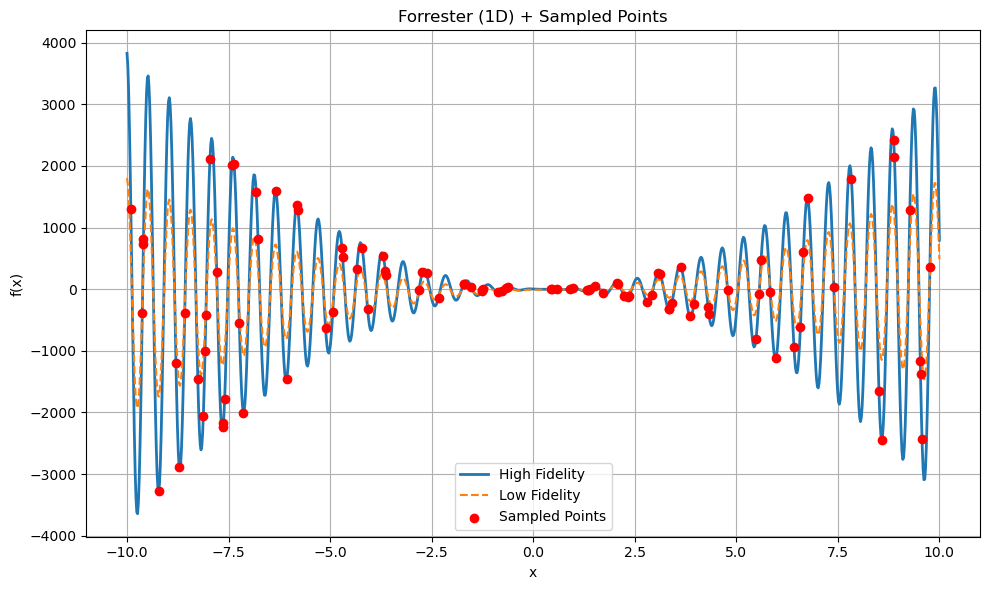

In [ ]:
# 시각화 (탐색한 점들 포함)
plot_mf_function_with_samples(forrester, result=results_dict['RandomSearch'][0])